### Run preliminary imports, set directories, etc.

In [1]:
import numpy as np
import pandas as pd
import sys, requests, json
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# for interactive sliders, etc.
from ipywidgets import interact, interactive, fixed, interact_manual

# for getting discovery date from TNS
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

#https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05

def dataPlot(x, y, dx=None, dy=None, sp=None, label=None, fmt='bo', ecolor='k', elinewidth=None, barsabove = False, capsize=1, logx=False, logy=False):
    if sp == None:
        sp = matlib.subplot(111)
    if dx is None and dy is None:
        if logy:
            if logx:
                plot, = sp.loglog(x, y, fmt)
            else:
                plot, = sp.semilogy(x, y, fmt)
        elif logx:
            plot, = sp.semilogx(x, y, fmt)
        else:
            if barsabove:
                plot, dplot,dummy = sp.errorbar(x, y, label=label, fmt=fmt, capsize=capsize, barsabove=barsabove)
            else:
                plot, = sp.plot(x, y, fmt)
        return sp, plot, None
    else:
        if logy:
            sp.set_yscale("log", nonposx='clip')
        if logx:
            sp.set_xscale("log", nonposx='clip')
        plot, dplot, dummy = sp.errorbar(x, y, xerr=dx, yerr=dy, label=label, fmt=fmt, ecolor=ecolor, elinewidth=elinewidth, capsize=capsize, barsabove=barsabove)
        return sp, plot, dplot

lc_info = pdastrostatsclass()

In [2]:
# Enter your data directory (where the SN light curves are located) here:
global dir
dir = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/'

Information about template changes at MJDs 58417 and 58882: https://fallingstar-data.com/forcedphot/faq/

### Load in light curves
Enter the TNS name for each SN you wish to load in and examine/cut in the cell below.

In [3]:
# Enter each SN's TNS name here:
#lc_info.t['tnsname'] = ['2019vxm']
#lc_info.t['mjdstart'] = [None] * len(lc_info.t['tnsname'])

# Optionally, enter each SN's discovery date (start of SN) here:
#lc_info.t['mjdstart'] = [59005.264,58818.04,58975.20256,58152.631331,58014.31,58153.49,None]

lc_info.t['tnsname'] = ['2020lse','2019vxm','2020jfo','2017gjn','2017glq','2017gup','2017guu','2017guv','2017haf','2017gqr','2017guh','2017gvp','2017ghu','2017hgz','2017hjw','2017hjy','2017hoq','2017hpa','2017hou','2017igf','2017isq','2017gxq','2017isj','2017iyb','2017iji','2017jav','2017iyw','2017jyl','2018cqw','2020ejm','2017izu','2019syd','2017gjd','2018jaj','2018jov','2018jaz','2018jaz','2018imd','2018kfv','2017jd','2018pc','2020fcw','2018hkq','2019wdx','2018lqy','2018gfi','2018K','2020dkm','2018yh','2020afp','2019wrz','2018gv','2018iq','2018gl','2018kp','2018oh','2018pv','2018xx','2018yu','2018aaz','2018zz','2018ajp','2018aqh','2018aoz','2018aqi','2018azu','2018aye','2018cnj','2018cqj','2018cuw','2018dda','2018dzy','2018ebk','2018ddi','2018enc','2018epx','2018etm','2018feb','2018fop','2018fli','2018fnq','2018fhx']
lc_info.t['mjdstart'] = [58955.26,58818.04,58925.20,57994.85992,57999.35754,58013.556,58009.58899,58011.305,58026.5,58005.1567,58014.31,58019.48,57991.4866,58036.02,58040.57399,58040.49699,58047.551,58051.34602,58050.37014,58075.59,58091.618,58013.453,58089.34568,58103.44699,58077.64,58106.24301,58105.3,58117.546,58287.2,58919.23791,58101.97699,58767.10699,57994.09,58447.48199,58460.583,58442.51023,58442.51023,58436.8626,58468.28699,57762.21399,58152.75,58936.437,58406.37,58824.38,58358.39,58373.4,58121.13589,58904.44051,58173.25,58866.66,58832.48,58133.68132,58137.49453,58131.56999,58142.36257,58153.49,58152.63133,58170.38199,58178.223,58183.56689,58180.92,58195.81,58213.44899,58210.30899,58214.07,58220.28699,58229.31,58266.61199,58282.268,58293.515,58303.96,58315.59399,58315.55199,58301.44,58332.32699,58335.605,58338.343,58346.16399,58351.56899,58343.15199,58361.08,58351.38]
lc_info.t['classification'] = [None] * len(lc_info.t['tnsname'])

# Enter api_key if mjdstarts not entered in manually and accessing TNS for discovery dates
global api_key
api_key = None

In [4]:
# set up the rest of lc_info (discovery date, loading in lc, etc.)

def get_tns_data(tnsname):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':api_key,'data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)

def get_disc_date(tnsname):
	json_data = get_tns_data(tnsname)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	return disc_date

def get_disc_date_loop(lc_info):
	for index in lc_info.ix_null(colnames=['mjdstart']):
		disc_date = get_disc_date(lc_info.t.loc[index,'tnsname'])
		lc_info.t.loc[index,'mjdstart'] = disc_date
	return lc_info

def correct4template(lc_info, index):
	#lc_info.t.loc[index,'lc'].getindices()
	#print(lc_info.t.loc[index,'lc'], lc_info.t.loc[index,'lc'].t)
	lc = lc_info.t.loc[index,'lc']
	baseline = lc.ix_inrange(colnames=['MJD'],uplim=lc_info.t.loc[index,'mjdstart'],exclude_uplim=True) 
	b_goodx2_i = lc.ix_inrange(colnames=['chi/N'],uplim=5,indices=baseline)
	#b_badx2_i = AnotB(baseline,b_goodx2_i)

	median_bflux = np.median(lc_info.t.loc[index,'lc'].t.loc[b_goodx2_i,'uJy'])

	# subtract median of baseline flux with x2 < 5 from all measurements to account for template shifts
	print(f'Subtracting median of baseline flux with chi-square ≤ %d {median_bflux:0.1f} uJy from light curve flux due to potential flux in the template...' % 5)
	lc_info.t.loc[index,'lc'].t['uJy'] -= median_bflux
	
	return lc_info

def load_lc_loop(lc_info):
	for index in range(0,len(lc_info.t)):
		lc_info.t.loc[index,'lc'] = pdastrostatsclass()
		filename = dir+lc_info.t.loc[index,'tnsname']+'/'+lc_info.t.loc[index,'tnsname']+'_i000.o.lc.txt'
		try:
			lc_info.t.loc[index,'lc'].load_spacesep(filename,delim_whitespace=True)
		except Exception as e:
			print('Could not load light curve for SN %s at %s: %s' % (lc_info.t.loc[index,'tnsname'], filename, str(e)))
			sys.exit()

		lc_info = correct4template(lc_info, index)

		# add flux/dflux column
		print('Adding uJy/duJy column to light curve...')
		lc_info.t.loc[index,'lc'].t['uJy/duJy'] = lc_info.t.loc[index,'lc'].t['uJy']/lc_info.t.loc[index,'lc'].t['duJy']
		lc_info.t.loc[index,'lc'].t = lc_info.t.loc[index,'lc'].t.replace([np.inf, -np.inf], np.nan)
	
	print('Success')
	return lc_info

print('Obtaining discovery date information from TNS if needed...')
lc_info.t['lc'] = [None] * len(lc_info.t)
lc_info = get_disc_date_loop(lc_info)
lc_info.write(columns=['tnsname','mjdstart','classification'])
print('\nLoading in light curves...')
lc_info = load_lc_loop(lc_info)

Obtaining discovery date information from TNS if needed...
tnsname    mjdstart classification
2020lse 58955.26000           None
2019vxm 58818.04000           None
2020jfo 58925.20000           None
2017gjn 57994.85992           None
2017glq 57999.35754           None
2017gup 58013.55600           None
2017guu 58009.58899           None
2017guv 58011.30500           None
2017haf 58026.50000           None
2017gqr 58005.15670           None
2017guh 58014.31000           None
2017gvp 58019.48000           None
2017ghu 57991.48660           None
2017hgz 58036.02000           None
2017hjw 58040.57399           None
2017hjy 58040.49699           None
2017hoq 58047.55100           None
2017hpa 58051.34602           None
2017hou 58050.37014           None
2017igf 58075.59000           None
2017isq 58091.61800           None
2017gxq 58013.45300           None
2017isj 58089.34568           None
2017iyb 58103.44699           None
2017iji 58077.64000           None
2017jav 58106.24301           N

In [5]:
# Enter the scaling parameter for the plots' upper y limit (ylim_upper = scale * 95th percentile flux)
global scale
scale = 2

In [ ]:
# plot each light curve

def get_xth_percentile_flux(info, percentile, indices):
    if len(indices)==0: 
        return None
    else:
        return np.percentile(info['lc'].t.loc[indices, 'uJy'], percentile)

def prelim_plot_lc(info, xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('uJy')
    ax.set_xlabel('MJD')
    ax.set_title('SN '+info['tnsname']+' Light Curve')
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')

    if xlim_lower is None: xlim_lower = info['mjdstart']-100
    if xlim_upper is None: xlim_upper = info['mjdstart']+400
    ax.set_xlim(xlim_lower, xlim_upper)

    if ylim_lower is None: ylim_lower = -200
    if ylim_upper is None: ylim_upper = scale*get_xth_percentile_flux(info, 95, np.where(info['lc'].t['MJD'] > info['mjdstart'])[0])
    ax.set_ylim(ylim_lower,ylim_upper)
    
    return fig, ax

def plot_lc_mjdstart(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    duringsn = np.where(info['lc'].t['MJD'] > info['mjdstart'])[0]

    fig, ax = prelim_plot_lc(info)

    sp, plot_baseline, dplot = dataPlot(info['lc'].t.loc[baseline,'MJD'], info['lc'].t.loc[baseline,'uJy'], sp=ax)
    matlib.setp(plot_baseline,ms=5,color='b',marker='o',label='Baseline flux')

    sp, plot_aftersn, dplot = dataPlot(info['lc'].t.loc[duringsn,'MJD'], info['lc'].t.loc[duringsn,'uJy'], sp=ax)
    matlib.setp(plot_aftersn,ms=5,color='c',marker='o',label='During and after SN')

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return info

for index in range(0,len(lc_info.t)):
    plot_lc_mjdstart(lc_info.t.loc[index])

### Remove faint SNe

In [6]:
# Enter the limit for the standard deviation calculated during the 3-sigma cut
# that will determine a SN's classification ("good" or "bad").
global stdev_limit
stdev_limit = 1.5

# Enter the limit for the percent of measurements clipped during the 3-sigma cut 
# that will determine a SN's classification ("good" or "bad").
global clippercent_limit
clippercent_limit = 5.0

In [7]:
# estimate rough brightness and confirm/change classification of each SN
# estimate rough brightness of each SN by getting 90th percentile flux from mjdstart to mjdstart+60 and determine if SN is a good candidate
# to confirm their classifications, take the baseline uJy/duJy and apply a 3-sigma cut. "Bad" SNe will have: sigma > 1.5, % data cut > 5%

def remove_SN(lc_info,index):
    print('Removing SN at index %d...' % index)
    lc_info.t = lc_info.t.drop([index])
    lc_info.t = lc_info.t.reset_index(drop=True)
    return lc_info

def get_xth_percentile_flux(lc_info, percentile, indices):
    if len(indices)==0: 
        return None
    else:
        return np.percentile(lc_info['lc'].t.loc[indices, 'uJy'], percentile)

def get_90th_percentile_SNflux_loop(lc_info):
    index = 0
    while index < len(lc_info.t):
        indices = AandB(np.where(lc_info.t.loc[index,'lc'].t['MJD']>lc_info.t.loc[index,'mjdstart'])[0], np.where(lc_info.t.loc[index,'lc'].t['MJD']<lc_info.t.loc[index,'mjdstart']+60)[0])
        flux = get_xth_percentile_flux(lc_info.t.loc[index], 90, indices)
        if flux is None:
            print('WARNING: For %s, 90th percentile flux not found' % (lc_info.t.loc[index,'tnsname']))
            lc_info = remove_SN(lc_info,index)
        elif(flux > 1000):
            print('For %s, 90th percentile flux %0.2f is over 1000 ' % (lc_info.t.loc[index,'tnsname'], flux) + u'\u2713')
            index += 1
        else:
            print('WARNING: For %s, 90th percentile flux %0.2f is under 1000\nRemoving SN from list? (y/n)' % (lc_info.t.loc[index,'tnsname'], flux))
            #answer = input()
            #if (answer == 'y'):
            lc_info = remove_SN(lc_info,index)
            #else:
                #index += 1
    return lc_info

def sigmacut_lc(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    info['lc'].calcaverage_sigmacutloop('uJy/duJy',noisecol=None,indices=baseline,verbose=1,Nsigma=3.0,median_firstiteration=True)
    print('stdev: ',info['lc'].statparams['stdev'],', % data clipped: ',100*info['lc'].statparams['Nclip']/len(info['lc'].t))
    output = 'Classified as '
    if info['lc'].statparams['stdev'] is None or info['lc'].statparams['Nclip'] is None:
        classification = 'bad'
    elif(info['lc'].statparams['stdev']<stdev_limit and (100*info['lc'].statparams['Nclip']/len(info['lc'].t))<clippercent_limit):
        classification = 'good'
    else: 
        classification = 'bad'
    output += classification + ' SN; '
    if(info['classification']==classification):
        output += 'consistent with preliminary classification ' + u'\u2713'
    else:
        output += 'WARNING: not consistent with preliminary classification (\'%s\')\nReclassifying in table...' % info['classification']
        info['classification'] = classification
    print(output)
    return info

def sigmacut_lc_loop(lc_info):
    for index in range(0, len(lc_info.t)):
        print('Sigmacutting %s...' % lc_info.t.loc[index,'tnsname'])
        lc_info.t.loc[index] = sigmacut_lc(lc_info.t.loc[index])
    return lc_info

lc_info = get_90th_percentile_SNflux_loop(lc_info)
print('\nRevised sample of SNe (only SNe with high flux):')
lc_info.write(columns=['tnsname','mjdstart','classification'])

print('\nstdev limit: %0.1f, %% data clipped limit: %0.1f' % (stdev_limit, clippercent_limit))
lc_info = sigmacut_lc_loop(lc_info)
print('\nRevised sample of bright SNe (all SNe reclassified as good or bad):')
print(lc_info.t[['tnsname','mjdstart','classification']].to_string())
#lc_info.write(columns=['tnsname','mjdstart','classification'])

For 2020lse, 90th percentile flux 1099.20 is over 1000 ✓
For 2019vxm, 90th percentile flux 5818.20 is over 1000 ✓
For 2020jfo, 90th percentile flux 5362.40 is over 1000 ✓
For 2017gjn, 90th percentile flux 2906.40 is over 1000 ✓
For 2017glq, 90th percentile flux 5627.00 is over 1000 ✓
Removing SN from list? (y/n)
Removing SN at index 5...
Removing SN from list? (y/n)
Removing SN at index 5...
Removing SN from list? (y/n)
Removing SN at index 5...
For 2017haf, 90th percentile flux 1695.60 is over 1000 ✓
Removing SN from list? (y/n)
Removing SN at index 6...
For 2017guh, 90th percentile flux 2342.00 is over 1000 ✓
For 2017gvp, 90th percentile flux 1138.40 is over 1000 ✓
Removing SN from list? (y/n)
Removing SN at index 8...
For 2017hgz, 90th percentile flux 2479.40 is over 1000 ✓
For 2017hjw, 90th percentile flux 1369.50 is over 1000 ✓
For 2017hjy, 90th percentile flux 2006.50 is over 1000 ✓
For 2017hoq, 90th percentile flux 1229.60 is over 1000 ✓
For 2017hpa, 90th percentile flux 2200.10

### Plot S/N and Chi-Square Histograms

In [ ]:
def plot_stn_hist(info, stn_xlim=None, x2_goodstn_xlim=None, x2_badstn_xlim=None):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    good_stn_b = AandB(baseline,np.where(info['lc'].t['uJy/duJy'] < 3.0)[0])
    bad_stn_b = AandB(baseline,np.where(info['lc'].t['uJy/duJy'] >= 3.0)[0])

    fig, axes = plt.subplots(nrows=1, ncols=3)
    stn, x2_goodstn, x2_badstn = axes.flatten()
    plt.suptitle('SN %s uJy/duJy and Chi-Square Distributions' % lc_info.t.loc[index,'tnsname'],fontsize=15, y=1)

    stn.set_title('uJy/duJy Distribution')
    stn.set_xlabel('uJy/duJy')
    if not(stn_xlim is None) and len(baseline)>0: 
        if stn_xlim[0] is None: stn_xlim[0] = min(info['lc'].t.loc[baseline, 'uJy/duJy'])
        if stn_xlim[1] is None: stn_xlim[1] = max(info['lc'].t.loc[baseline, 'uJy/duJy'])
        stn.hist(info['lc'].t.loc[baseline, 'uJy/duJy'], bins=30, range=(stn_xlim[0],stn_xlim[1]))
    else:
        stn.hist(info['lc'].t.loc[baseline, 'uJy/duJy'], bins=30)

    x2_goodstn.set_title('Chi-Square Distribution for Data with uJy/duJy<3')
    x2_goodstn.set_xlabel('Chi-Square')
    if not(x2_goodstn_xlim is None) and len(good_stn_b)>0: 
        if x2_goodstn_xlim[0] is None: x2_goodstn_xlim[0] = min(info['lc'].t.loc[good_stn_b, 'chi/N'])
        if x2_goodstn_xlim[1] is None: x2_goodstn_xlim[1] = max(info['lc'].t.loc[good_stn_b, 'chi/N'])
        x2_goodstn.hist(info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30, range=(x2_goodstn_xlim[0], x2_goodstn_xlim[1]))
    else:
        x2_goodstn.hist(info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30)

    x2_badstn.set_title('Chi-Square Distribution for Data with uJy/duJy>=3')
    x2_badstn.set_xlabel('Chi-Square')
    if not(x2_badstn_xlim is None) and len(bad_stn_b)>0: 
        if x2_badstn_xlim[0] is None: x2_badstn_xlim[0] = min(info['lc'].t.loc[bad_stn_b, 'chi/N'])
        if x2_badstn_xlim[1] is None: x2_badstn_xlim[1] = max(info['lc'].t.loc[bad_stn_b, 'chi/N'])
        x2_badstn.hist(info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30, range=(x2_badstn_xlim[0], x2_badstn_xlim[1]))
    else:
        x2_badstn.hist(info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30)

stn_xlims = [[None,300], None, None, None, None]
x2_goodstn_xlims = [[None,20], None, None, None, None]
x2_badstn_xlims = [[None,2500], [None,None], [None,None], [None,None], [None,None]]

for index in range(0,len(lc_info.t)):
    plot_stn_hist(lc_info.t.loc[index], stn_xlims[index], x2_goodstn_xlims[index]) #, x2_badstn_xlims[index])

In [ ]:
def plot_stn_hist(info, stn_xlim=None, x2_xlim=None):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    good_stn_b = AandB(baseline,np.where(info['lc'].t['uJy/duJy'] < 3.0)[0])
    bad_stn_b = AandB(baseline,np.where(info['lc'].t['uJy/duJy'] >= 3.0)[0])
    good_x2_b = AandB(baseline,np.where(info['lc'].t['chi/N'] < 5.0)[0])
    bad_x2_b = AandB(baseline,np.where(info['lc'].t['chi/N'] >= 5.0)[0])

    fig, axes = plt.subplots(nrows=1, ncols=2)
    stn, x2 = axes.flatten()
    plt.suptitle('SN %s uJy/duJy and Chi-Square Distributions' % lc_info.t.loc[index,'tnsname'],fontsize=15, y=1)

    stn.set_title('uJy/duJy Distribution')
    stn.set_xlabel('uJy/duJy')
    red = mpatches.Patch(color='green', label='Data with Chi-Square<5')
    green = mpatches.Patch(color='red', label='Data with Chi-Square>=5')
    stn.legend(handles=[red, green])
    if not(stn_xlim is None) and len(baseline)>0: 
        if stn_xlim[0] is None: stn_xlim[0] = min(info['lc'].t.loc[baseline, 'uJy/duJy'])
        if stn_xlim[1] is None: stn_xlim[1] = max(info['lc'].t.loc[baseline, 'uJy/duJy'])
        stn.hist(info['lc'].t.loc[good_x2_b, 'uJy/duJy'], bins=30, color='green', alpha=0.5, range=(stn_xlim[0],stn_xlim[1]), density=True)
        stn.hist(info['lc'].t.loc[bad_x2_b, 'uJy/duJy'], bins=30, color='red', alpha=0.5, range=(stn_xlim[0],stn_xlim[1]), density=True)
    else:
        stn.hist(info['lc'].t.loc[good_x2_b, 'uJy/duJy'], bins=30, color='green', alpha=0.5, density=True)
        stn.hist(info['lc'].t.loc[bad_x2_b, 'uJy/duJy'], bins=30, color='red', alpha=0.5, density=True)

    x2.set_title('Chi-Square Distribution')
    x2.set_xlabel('Chi-Square')
    red = mpatches.Patch(color='green', label='Data with uJy/duJy<3')
    green = mpatches.Patch(color='red', label='Data with uJy/duJy>=3')
    x2.legend(handles=[red, green])
    if not(x2_xlim is None) and len(baseline)>0:
        if x2_xlim[0] is None: x2_xlim[0] = min(info['lc'].t.loc[baseline, 'chi/N'])
        if x2_xlim[1] is None: x2_xlim[1] = max(info['lc'].t.loc[baseline, 'chi/N'])
        x2.hist(info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30, color='green', alpha=0.5, range=(x2_xlim[0],x2_xlim[1]), density=True)
        x2.hist(info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30, color='red', alpha=0.5, range=(x2_xlim[0],x2_xlim[1]), density=True)
    else:
        x2.hist(info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30, color='green', alpha=0.5, density=True)
        x2.hist(info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30, color='red', alpha=0.5, density=True)

stn_xlims = [[None,300], None, None, None, None]
x2_xlims = [[None,3000], None, [-1,10], [0,11], None]

for index in range(0,len(lc_info.t)):
    plot_stn_hist(lc_info.t.loc[index], stn_xlims[index], x2_xlims[index])

### Examine each region defined by the ATLAS template changes and its chi-squares
There are two ATLAS template changes, one at MJD = 58417 and one at MJD = 58882.

In [8]:
global hockeystick_cut
global hockeystick_cut_pcutoff
global extendedtail_cut
global extendedtail_cut_pcutoff
# if % data with x2 greater than hockeystick_cut is >hockeystick_cut_pcutoff%, classify as hockeystick.
hockeystick_cut = 100
hockeystick_cut_pcutoff = 1.0
# if % data with x2 greater than extendedtail_cut and smaller than hockeystick_cut is >extendedtail_cut_pcutoff%, classify as extended tail.
extendedtail_cut = 5
extendedtail_cut_pcutoff = 1.0
# else classify as well-behaved.

Template changes at 58417 and 58882 MJD
PSF chi-square cut for hockeystick classification: 100; PSF chi-square cut for extended tail classification: 5
PSF chi-square hockeystick cut percent cutoff: 1.0%; PSF chi-square extended tail cut percent cutoff: 1.0%

SN 2020lse MJD region states w.r.t. PSF chi-square values:
  region    n start_index end_index     mjd_start Phockeystick Pextendedtail Pwellbehaved          state
0      b  850           0       849  57735.637639          0.0      0.235294    99.764706   well-behaved
1   b_t0  456           0       455  57735.637639          0.0      0.219298    99.780702   well-behaved
2   b_t1  328         456       783  58455.636498          0.0      0.304878    99.695122   well-behaved
3   b_t2   66         784       849  58883.491076          0.0           0.0        100.0   well-behaved
4     sn  299         850      1148  58955.410202          0.0      1.337793    98.662207  extended tail
5  sn_t0    0         NaN       NaN           NaN   

,tnsname,classification,b_t0,b_t1,b_t2,sn_t0,sn_t1,sn_t2,b,sn
0,2020lse,good,well-behaved,well-behaved,well-behaved,nan,nan,extended tail,well-behaved,extended tail
1,2019vxm,bad,hockeystick,hockeystick,nan,nan,nan,hockeystick,hockeystick,hockeystick
2,2020jfo,good,well-behaved,well-behaved,nan,nan,nan,extended tail,well-behaved,extended tail
3,2017gjn,bad,well-behaved,nan,nan,extended tail,extended tail,extended tail,well-behaved,extended tail
4,2017glq,bad,hockeystick,nan,nan,extended tail,hockeystick,well-behaved,hockeystick,extended tail
5,2017haf,bad,hockeystick,nan,nan,extended tail,extended tail,extended tail,hockeystick,extended tail
6,2017guh,bad,extended tail,nan,nan,hockeystick,hockeystick,hockeystick,extended tail,hockeystick
7,2017gvp,bad,extended tail,nan,nan,extended tail,extended tail,extended tail,extended tail,extended tail
8,2017hgz,bad,hockeystick,nan,nan,extended tail,extended tail,extended tail,hockeystick,extended tail
9,2017hjw,good,extended tail,nan,nan,well-behaved,well-behaved,well-behaved,extended tail,well-behaved


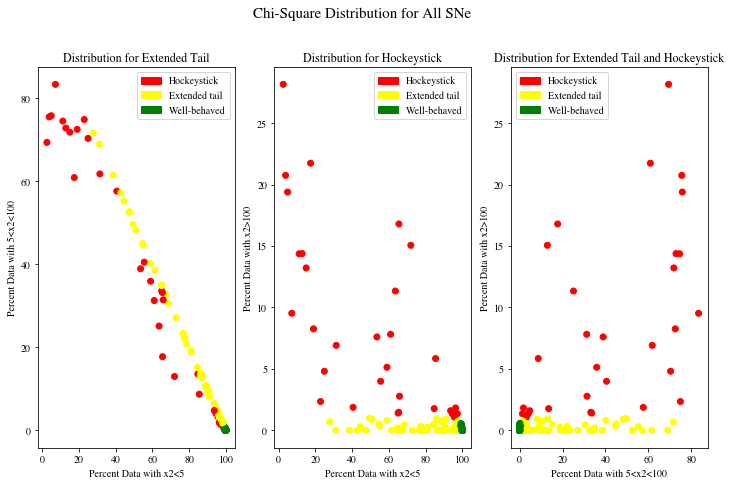

In [9]:
# divide light curve into 6 MJD regions: baseline (t0, t1, t2), SN (t0, t1, t2).
# for each MJD region, calculate the number of detections. If n < 50, disregard. If n > 50, continue.
# hockeystick: % data with x2>100
# extended tail: % data with 5<x2<100
# well-behaved: % data with x2<5

def get_region_table_plot_colors(regionstates):
    colors = []
    for state in regionstates.loc[[1,2,3,5,6,7],'state']:
        if state == 'hockeystick':
            colors.append('red')
        elif state == 'extended tail':
            colors.append('yellow')
        else:
            colors.append('green')
    return colors 

def get_regionstates_allsne_table_colors(val):
    if val == 'hockeystick':
        color = 'red'
    elif val == 'extended tail':
        color = 'yellow'
    elif val == 'well-behaved':
        color = 'green'
    else:
        color = 'white'
    return 'background-color: %s' % color

def get_ranges(info):
    baseline = np.where(info['lc'].t['MJD'] < info['mjdstart'])[0]
    aftersnstart = AnotB(info['lc'].getindices(),baseline)
    ranges = {}
    ranges[0] = baseline
    ranges[1] = AandB(baseline, np.where(info['lc'].t['MJD'] < tchange1)[0]) # b_t0
    ranges[2] = AandB(baseline, AandB(np.where(info['lc'].t['MJD'] > tchange1)[0], np.where(info['lc'].t['MJD'] < tchange2)[0])) # b_t1
    ranges[3] = AandB(baseline, np.where(info['lc'].t['MJD'] > tchange2)[0]) # b_t2
    ranges[4] = aftersnstart
    ranges[5] = AandB(aftersnstart, np.where(info['lc'].t['MJD'] < tchange1)[0]) # sn_t0
    ranges[6] = AandB(aftersnstart, AandB(np.where(info['lc'].t['MJD'] > tchange1)[0], np.where(info['lc'].t['MJD'] < tchange2)[0])) # sn_t1
    ranges[7] = AandB(aftersnstart, np.where(info['lc'].t['MJD'] > tchange2)[0]) # sn_t2
    return ranges

def get_region_table(info):
    regionstates = pdastrostatsclass(columns=['region','n','start_index','end_index','mjd_start','Phockeystick','Pextendedtail','Pwellbehaved','state'])
    regionstates.t['region'] = ['b','b_t0','b_t1','b_t2','sn','sn_t0','sn_t1','sn_t2']
    ranges = get_ranges(info)

    for index in range(0,len(ranges)):
        regionstates.t.loc[index,'n'] = len(ranges[index])

        if len(ranges[index] > 0): 
            regionstates.t.loc[index,'mjd_start'] = info['lc'].t.loc[ranges[index][0],'MJD']
            regionstates.t.loc[index,'start_index'] = ranges[index][0]
            regionstates.t.loc[index,'end_index'] = ranges[index][-1]
        else:
            regionstates.t.loc[index,'mjd_start'] = np.nan
            regionstates.t.loc[index,'start_index'] = np.nan
            regionstates.t.loc[index,'end_index'] = np.nan
        if len(ranges[index]) < 50:
            regionstates.t.loc[index,'Phockeystick'] = np.nan
            regionstates.t.loc[index,'Pextendedtail'] = np.nan
            regionstates.t.loc[index,'Pwellbehaved'] = np.nan
            regionstates.t.loc[index,'state'] = np.nan
            continue

        Phockeystick_i = AandB(ranges[index], np.where(info['lc'].t['chi/N']>=hockeystick_cut)[0])
        Pextendedtail_i = AandB(ranges[index], AandB(np.where(info['lc'].t['chi/N']>=extendedtail_cut)[0], np.where(info['lc'].t['chi/N']<hockeystick_cut)[0]))
        Pwellbehaved_i = AandB(ranges[index], np.where(info['lc'].t['chi/N']<extendedtail_cut)[0])

        regionstates.t.loc[index,'Phockeystick'] = 100.0*len(Phockeystick_i)/len(ranges[index])
        regionstates.t.loc[index,'Pextendedtail'] = 100.0*len(Pextendedtail_i)/len(ranges[index])
        regionstates.t.loc[index,'Pwellbehaved'] = 100.0*len(Pwellbehaved_i)/len(ranges[index])
        
        if(regionstates.t.loc[index,'Phockeystick'] > hockeystick_cut_pcutoff):
            regionstates.t.loc[index,'state'] = 'hockeystick'
        elif(regionstates.t.loc[index,'Pextendedtail'] > extendedtail_cut_pcutoff):
            regionstates.t.loc[index,'state'] = 'extended tail'
        else:
            regionstates.t.loc[index,'state'] = 'well-behaved'

    return regionstates

def get_region_table_loop(lc_info):
    regionstates_allsne = pd.DataFrame(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])
    
    # prelim plots of distribution for percent cut
    fig, axes = plt.subplots(nrows=1, ncols=3)
    et, hs, eths = axes.flatten()
    plt.suptitle('Chi-Square Distribution for All SNe',fontsize=15, y=1)
    et.set_title('Distribution for Extended Tail')
    et.set_ylabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
    et.set_xlabel('Percent Data with x2<%d' % extendedtail_cut)
    hs.set_title('Distribution for Hockeystick')
    hs.set_ylabel('Percent Data with x2>%d' % hockeystick_cut)
    hs.set_xlabel('Percent Data with x2<%d' % extendedtail_cut)
    eths.set_title('Distribution for Extended Tail and Hockeystick')
    eths.set_xlabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
    eths.set_ylabel('Percent Data with x2>%d' % hockeystick_cut)

    hockeystick_counter = 0
    extendedtail_counter = 0
    wellbehaved_counter = 0
    for index in range(0,len(lc_info.t)):
        # get region table
        regionstates = get_region_table(lc_info.t.loc[index])
        print('SN %s MJD region states w.r.t. PSF chi-square values:' % (lc_info.t.loc[index,'tnsname'])) 
        print(regionstates.t.to_string(),'\n')

        ix = [1,2,3,5,6,7] # don't count repeat b and sn regions

        hockeystick_counter += len(np.where(regionstates.t.loc[ix,'state']=='hockeystick')[0])
        extendedtail_counter += len(np.where(regionstates.t.loc[ix,'state']=='extended tail')[0])
        wellbehaved_counter += len(np.where(regionstates.t.loc[ix,'state']=='well-behaved')[0])

        # plot
        colors = get_region_table_plot_colors(regionstates.t)
        et.scatter(regionstates.t.loc[ix,'Pwellbehaved'], regionstates.t.loc[ix,'Pextendedtail'], c=colors)
        hs.scatter(regionstates.t.loc[ix,'Pwellbehaved'], regionstates.t.loc[ix,'Phockeystick'], c=colors)
        eths.scatter(regionstates.t.loc[ix,'Pextendedtail'], regionstates.t.loc[ix,'Phockeystick'], c=colors)

        # classify each region
        regionstates_allsne.loc[index,'tnsname'] = lc_info.t.loc[index,'tnsname']
        regionstates_allsne.loc[index,'classification'] = lc_info.t.loc[index,'classification']
        for i in range(0,len(regionstates.t['region'])):
            regionstates_allsne.loc[index,regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'state']

        # update lc_info
        et_colname = 'Pextendedtail_'
        hs_colname = 'Phockeystick_'
        for i in range(0,4):
            lc_info.t.loc[index, et_colname+regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'Pextendedtail']
            lc_info.t.loc[index, hs_colname+regionstates.t.loc[i,'region']] = regionstates.t.loc[i,'Phockeystick']
    
    print('Hockeystick ranges: %d\nExtended tail ranges: %d\nWell-behaved ranges: %d\n' % (hockeystick_counter, extendedtail_counter, wellbehaved_counter))
    
    # legends for plots of distribution for percent cut
    red = mpatches.Patch(color='red', label='Hockeystick')
    yellow = mpatches.Patch(color='yellow', label='Extended tail')
    green = mpatches.Patch(color='green', label='Well-behaved')
    et.legend(handles=[red, yellow, green])
    hs.legend(handles=[red, yellow, green])
    eths.legend(handles=[red, yellow, green])

    return regionstates_allsne, lc_info

regionstates_allsne = pdastrostatsclass(columns=['tnsname','classification','b_t0','b_t1','b_t2','sn_t0','sn_t1','sn_t2'])

print('Template changes at %d and %d MJD' % (tchange1,tchange2))
print('PSF chi-square cut for hockeystick classification: %d; PSF chi-square cut for extended tail classification: %d' % (hockeystick_cut,extendedtail_cut))
print('PSF chi-square hockeystick cut percent cutoff: %0.1f%%; PSF chi-square extended tail cut percent cutoff: %0.1f%%\n' % (hockeystick_cut_pcutoff, extendedtail_cut_pcutoff))
regionstates_allsne.t, lc_info = get_region_table_loop(lc_info)
print(lc_info.t)
regionstates_allsne.t.style.applymap(get_regionstates_allsne_table_colors)

### Examine each region defined by the ATLAS template changes and its chi-squares in relation to S/N

In [ ]:
# for each well-behaved baseline region of all SNe, 3 histograms.
# histogram 1: S/N of all measurements with x2>hockeystick_cut.
# histogram 2: S/N of all measurements with hockeystick_cut>x2>extendedtail_cut.
# histogram 3: S/N of all measurements with extendedtail_cut>x2.
# repeat for each extended tail baseline region and for each hockeystick baseline region.

def get_state_expected_n(state):
    counter = 0
    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_info.t.loc[index])
        for b_region_i in range(0,3):
            if regionstates.t.loc[b_region_i,'state'] == state:
                counter += regionstates.t.loc[b_region_i,'n']
    return counter

def get_state_x2_expected_n(state, x2_lowlim=None, x2_uplim=None):
    counter = 0
    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_info.t.loc[index])
        for b_region_i in range(0,3):
            if regionstates.t.loc[b_region_i,'state'] == state:
                s = regionstates.t.loc[b_region_i,'start_index']
                e = regionstates.t.loc[b_region_i,'end_index']
                if not(x2_lowlim is None) and not(x2_uplim is None):
                    counter += len(AandB(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']>= x2_lowlim)[0], np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']<= x2_uplim)[0]))
                elif not(x2_lowlim is None):
                    counter += len(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']>= x2_lowlim)[0])
                elif not(x2_uplim is None):
                    counter += len(np.where(lc_info.t.loc[index,'lc'].t.loc[range(s,e+1),'chi/N']<= x2_uplim)[0])
    return counter

def get_state_baseline_allsne(state):
    state_baseline_allsne = pdastrostatsclass()
    for index in range(0,len(lc_info.t)):
        #print('SN ', lc_info.t.loc[index,'tnsname'])
        regionstates = get_region_table(lc_info.t.loc[index])
        #print(regionstates.t.to_string())
        # for each baseline region, check if state matches and if so add to state_baseline_allsne table
        for b_region_i in range(0,3):
            #print(b_region_i,regionstates.t.loc[b_region_i,'state'])
            if regionstates.t.loc[b_region_i,'state'] == state:
                #print('passed, adding: ', regionstates.t.loc[b_region_i,'start_index'], regionstates.t.loc[b_region_i,'end_index'])
                # add measurements within that region to state_baseline_allsne table
                state_baseline_allsne.t = pd.concat([state_baseline_allsne.t, 
                                                    lc_info.t.loc[index,'lc'].t.loc[range(regionstates.t.loc[b_region_i,'start_index'], 1+regionstates.t.loc[b_region_i,'end_index'])]], 
                                                    ignore_index=True)
    state_baseline_allsne.t['uJy/duJy'] = state_baseline_allsne.t['uJy']/state_baseline_allsne.t['duJy']
    state_baseline_allsne.t = state_baseline_allsne.t.replace([np.inf, -np.inf], np.nan)

    return state_baseline_allsne

def plot_stn_hist(state, state_baseline_allsne, hist, x2_lowlim=None, x2_uplim=None):
    indices = state_baseline_allsne.ix_inrange(colnames=['chi/N'], lowlim=x2_lowlim, uplim=x2_uplim)
    print('Expected %d indices and found %d indices for chi-square range ' % (get_state_x2_expected_n(state,x2_lowlim,x2_uplim), len(indices)), x2_lowlim, '-', x2_uplim)

    #print(state_baseline_allsne.t.loc[indices, 'uJy/duJy'].to_string())
    hist.hist(state_baseline_allsne.t.loc[indices, 'uJy/duJy'], bins=30) #, range=(0,20))
    
    title = 'For data with '
    if not(x2_uplim is None): title += '%0.1f>' % x2_uplim
    title += 'x2'
    if not(x2_lowlim is None): title += '>%0.1f' % x2_lowlim
    hist.set_title(title)
    hist.set_xlabel('uJy/duJy')

def plot_region_stn_hist(state):
    print('\nPlotting S/N Histograms for %s MJD Regions' % state.title())
    state_baseline_allsne = get_state_baseline_allsne(state)
    #print(state_baseline_allsne.t)
    print('Expected indices for this state: %d' % get_state_expected_n(state))

    fig, axes = plt.subplots(nrows=1, ncols=3)
    plt.suptitle('S/N Frequencies for Chi-Square Ranges in %s MJD Regions' % state.title(), fontsize=15, y=1)
    hs, et, wb = axes.flatten()

    plot_stn_hist(state, state_baseline_allsne, hs, x2_lowlim=hockeystick_cut)
    plot_stn_hist(state, state_baseline_allsne, et, x2_lowlim=extendedtail_cut, x2_uplim=hockeystick_cut)
    plot_stn_hist(state, state_baseline_allsne, wb, x2_uplim=extendedtail_cut)


plot_region_stn_hist('well-behaved') 
plot_region_stn_hist('extended tail')
plot_region_stn_hist('hockeystick')

### Recalculate cut limits for each SN based on contamination and loss

In [10]:
# Enter the contamination limit (contamination = Nbad,kept/Nkept must be <= contam_lim%):
global contam_lim
contam_lim = 15.0

# Enter the loss limit (loss = Ngood,cut/Ngood must be >= loss_lim%):
global loss_lim
loss_lim = 10.0

# Enter the limit to prioritize (must be 'loss_lim' or 'contam_lim', based on which is more important):
global lim_to_prioritize
lim_to_prioritize = 'loss_lim'

# Enter the parameters for the chi-square cut (minimum cut, maximum cut, and step):
global cut_start
global cut_stop
global cut_step
cut_start = 3 # this is inclusive
cut_stop = 50 # this is inclusive
cut_step = 1

# Enter the signal-to-noise cut that will determine a "good" measurement from
# a "bad" measurement:
global stn_cut
stn_cut = 3

In [11]:
# 1. static cut at x2=50; get percent cut before and after mjdstart
# 2. for different x2 cuts decreasing from cut_stop and cut at stn_cut
#    and for only baseline calculate contam% and loss%

def plot_lim_cuts(info, lim_cuts, contam_lim_cut, loss_lim_cut, add2title=None):
    fig = plt.figure()
    plt.title('SN %s Dynamic PSF Chi-Square Cut (Baseline Only)' % (info['tnsname']))

    plt.axhline(linewidth=1,color='k')
    plt.xlabel('PSF Chi-Square Cut')
    plt.ylabel('% of Baseline Measurements')

    plt.axhline(loss_lim,linewidth=1,color='r',linestyle='--',label='Loss Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Loss'],ms=5,color='r',marker='o',label='Loss')
    plt.axvline(x=loss_lim_cut,color='r',label='Loss Cut')
    plt.axvspan(loss_lim_cut, cut_stop, alpha=0.2, color='r')

    plt.axhline(contam_lim,linewidth=1,color='g',linestyle='--',label='Contamination Limit')
    plt.plot(lim_cuts.t['PSF Chi-Square Cut'], lim_cuts.t['Contamination'],ms=5,color='g',marker='o',label='Contamination')
    plt.axvline(x=contam_lim_cut,color='g',label='Contamination Cut')
    plt.axvspan(cut_start, contam_lim_cut, alpha=0.2, color='g')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.tight_layout()

def get_lim_cuts_data(lc_info, index, cut, colname):
    indices = lc_info.t.loc[index,'lc'].ix_inrange(colnames=['MJD'],uplim=lc_info.t.loc[index,'mjdstart'],exclude_uplim=True)

    b_good_i = lc_info.t.loc[index,'lc'].ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    b_kept_i = lc_info.t.loc[index,'lc'].ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
    b_cut_i = AnotB(indices, b_kept_i)

    lc_info.t.loc[index,'%s_Ngood' % colname] = len(b_good_i)
    lc_info.t.loc[index,'%s_Nbad' % colname] = len(b_bad_i)
    lc_info.t.loc[index,'%s_Nkept' % colname] = len(b_kept_i)
    lc_info.t.loc[index,'%s_Ncut' % colname] = len(b_cut_i)
    lc_info.t.loc[index,'%s_Ngood,kept' % colname] = len(AandB(b_good_i,b_kept_i))
    lc_info.t.loc[index,'%s_Ngood,cut' % colname] = len(AandB(b_good_i,b_cut_i))
    lc_info.t.loc[index,'%s_Nbad,kept' % colname] = len(AandB(b_bad_i,b_kept_i))
    lc_info.t.loc[index,'%s_Nbad,cut' % colname] = len(AandB(b_bad_i,b_cut_i))
    lc_info.t.loc[index,'%s_Pgood,kept' % colname] = 100*len(AandB(b_good_i,b_kept_i))/len(indices)
    lc_info.t.loc[index,'%s_Pgood,cut' % colname] = 100*len(AandB(b_good_i,b_cut_i))/len(indices)
    lc_info.t.loc[index,'%s_Pbad,kept' % colname] = 100*len(AandB(b_bad_i,b_kept_i))/len(indices)
    lc_info.t.loc[index,'%s_Pbad,cut' % colname] = 100*len(AandB(b_bad_i,b_cut_i))/len(indices)
    lc_info.t.loc[index,'%s_Ngood,kept/Ngood' % colname] = 100*len(AandB(b_good_i,b_kept_i))/len(b_good_i)
    lc_info.t.loc[index,'%s_Ploss' % colname] = 100*len(AandB(b_good_i,b_cut_i))/len(b_good_i)
    lc_info.t.loc[index,'%s_Pcontamination' % colname] = 100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i)

    return lc_info

def get_lim_cuts(lc_info, index, lim_cuts):
    contam_lim_cut = None
    loss_lim_cut = None
    contam_case = None
    loss_case = None

    sortby_loss = lim_cuts.t.iloc[(lim_cuts.t['Ploss']).argsort()].reset_index()
    min_loss = sortby_loss.loc[0,'Ploss']
    max_loss = sortby_loss.loc[len(sortby_loss)-1,'Ploss']
    # if all loss below lim, loss_lim_cut is min cut
    if min_loss < loss_lim and max_loss < loss_lim:
        loss_case = 'below lim'
        loss_lim_cut = lim_cuts.t.loc[0,'PSF Chi-Square Cut']
    else:
        # else if all loss above lim, loss_lim_cut is min cut with min% loss
        if min_loss > loss_lim and max_loss > loss_lim:
            loss_case = 'above lim'
            a = np.where(lim_cuts.t['Ploss'] == min_loss)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            loss_lim_cut = c.loc[0,'PSF Chi-Square Cut']
        # else if loss crosses lim at some point, loss_lim_cut is min cut with max% loss <= loss_lim
        else:
            loss_case = 'crosses lim'
            valid_cuts = sortby_loss[sortby_loss['Ploss'] <= loss_lim]
            a = np.where(lim_cuts.t['Ploss'] == valid_cuts.loc[len(valid_cuts)-1,'Ploss'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of loss1 and loss2 (two points on either side of lim)
            loss1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[0,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[loss1_i,'Ploss'] == loss_lim:
                loss_lim_cut = lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut']
            else:
                loss2_i = loss1_i - 1
                x = np.array([lim_cuts.t.loc[loss1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[loss2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[loss1_i,'Pcontamination'], lim_cuts.t.loc[loss2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[loss1_i,'Ploss'], lim_cuts.t.loc[loss2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                loss_lim_cut = (loss_lim-loss_line[1])/loss_line[0]

    sortby_contam = lim_cuts.t.iloc[(lim_cuts.t['Pcontamination']).argsort()].reset_index()
    min_contam = sortby_contam.loc[0,'Pcontamination']
    max_contam = sortby_contam.loc[len(sortby_contam)-1,'Pcontamination']
    # if all contam below lim, contam_lim_cut is max cut
    if min_contam < contam_lim and max_contam < contam_lim:
        contam_case = 'below lim'
        contam_lim_cut = lim_cuts.t.loc[len(lim_cuts.t)-1,'PSF Chi-Square Cut']
    else:
        # else if all contam above lim, contam_lim_cut is max cut with min% contam
        if min_contam > contam_lim and max_contam > contam_lim:
            contam_case = 'above lim'
            a = np.where(lim_cuts.t['Pcontamination'] == min_contam)[0]
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            contam_lim_cut = c.loc[len(c)-1,'PSF Chi-Square Cut']
        # else if contam crosses lim at some point, contam_lim_cut is max cut with max% contam <= contam_lim
        else:
            contam_case = 'crosses lim'
            valid_cuts = sortby_contam[sortby_contam['Pcontamination'] <= contam_lim]
            a = np.where(lim_cuts.t['Pcontamination'] == valid_cuts.loc[len(valid_cuts)-1,'Pcontamination'])[0]
            # sort by cuts
            b = lim_cuts.t.iloc[a]
            c = b.iloc[(b['PSF Chi-Square Cut']).argsort()].reset_index()
            # get midpoint of contam1 and contam2 (two points on either side of lim)
            contam1_i = np.where(lim_cuts.t['PSF Chi-Square Cut'] == c.loc[len(c)-1,'PSF Chi-Square Cut'])[0][0]
            if lim_cuts.t.loc[contam1_i,'Pcontamination'] == contam_lim:
                contam_lim_cut = lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut']
            else:
                contam2_i = contam1_i + 1
                x = np.array([lim_cuts.t.loc[contam1_i,'PSF Chi-Square Cut'], lim_cuts.t.loc[contam2_i,'PSF Chi-Square Cut']])
                contam_y = np.array([lim_cuts.t.loc[contam1_i,'Pcontamination'], lim_cuts.t.loc[contam2_i,'Pcontamination']])
                loss_y = np.array([lim_cuts.t.loc[contam1_i,'Ploss'], lim_cuts.t.loc[contam2_i,'Ploss']])
                contam_line = np.polyfit(x,contam_y,1)
                loss_line = np.polyfit(x,loss_y,1)
                contam_lim_cut = (contam_lim-contam_line[1])/contam_line[0]

    lc_info = get_lim_cuts_data(lc_info, index, loss_lim_cut, 'loss_lim_cut')
    lc_info = get_lim_cuts_data(lc_info, index, contam_lim_cut, 'contam_lim_cut')

    return lc_info, contam_lim_cut, loss_lim_cut, contam_case, loss_case

def choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case):
# case 1 and 1: final_cut = 3
    # case 1 and 2: take limit of case 2
    # case 1 and 3: take limit of case 3
    # case 2 and 2: print lims don't work
    # case 2 and 3: choose_btwn_lim_cuts
    # case 3 and 3: choose_btwn_lim_cuts

    case1 = loss_case == 'below lim' or contam_case == 'below lim'
    case2 = loss_case == 'above lim' or contam_case == 'above lim'
    case3 = loss_case == 'crosses lim' or contam_case == 'crosses lim'

    final_cut = None
    if case1 and not case2 and not case3: # 1 and 1
        print('Valid chi-square cut range from %0.2f to %0.2f! Setting to 3...' % (loss_lim_cut, contam_lim_cut))
        final_cut = cut_start
    elif case1: # 1
        if case2: # and 2
            if loss_case == 'above lim':
                print('WARNING: contam_lim_cut <= %0.2f falls below limit %0.2f%%, but loss_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('WARNING: loss_lim_cut <= %0.2f falls below limit %0.2f%%, but contam_lim_cut >= %0.2f falls above limit %0.2f%%! Setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
        else: # and 3
            if loss_case == 'crosses lim':
                print('Contam_lim_cut <= %0.2f falls below limit %0.2f%% and loss_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (contam_lim_cut, contam_lim, loss_lim_cut, loss_lim, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Loss_lim_cut <= %0.2f falls below limit %0.2f%% and contam_lim_cut >= %0.2f crosses limit %0.2f%%, setting to %0.2f...' % (loss_lim_cut, loss_lim, contam_lim_cut, contam_lim, contam_lim_cut))
                final_cut = contam_lim_cut
    elif case2 and not case3: # 2 and 2
        print('ERROR: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f both fall above limits %0.2f%% and %0.2f%%! Try setting less strict limits. Setting final cut to nan.' % (loss_lim_cut, contam_lim_cut, loss_lim, contam_lim))
        final_cut = np.nan
    else: # 2 and 3 or 3 and 3
        if loss_lim_cut > contam_lim_cut:
            print('WARNING: chi-square loss_lim_cut >= %0.2f and contam_lim_cut <= %0.2f do not overlap! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f...' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
        else:
            print('Valid chi-square cut range from %0.2f to %0.2f! ' % (loss_lim_cut, contam_lim_cut))
            if lim_to_prioritize == 'contam_lim':
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, loss_lim_cut))
                final_cut = loss_lim_cut
            else:
                print('Prioritizing %s and setting to %0.2f... ' % (lim_to_prioritize, contam_lim_cut))
                final_cut = contam_lim_cut
    return final_cut

def get_lim_cuts_table(lc_info, index):
    print('abs(uJy/duJy) cut at %0.2f \nx2 cut from %0.2f to %0.2f inclusive, with step size %d' % (stn_cut,cut_start,cut_stop,cut_step))

    lim_cuts = pdastrostatsclass(columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                          'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                          'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
    
    lc = lc_info.t.loc[index,'lc']
    indices = lc.ix_inrange(colnames=['MJD'],uplim=lc_info.t.loc[index,'mjdstart'],exclude_uplim=True) 

    # static cut at x2 = 50
    #x2cut_50 = np.where(lc.t['chi/N'] < 50)[0]
    #print('Static chi square cut at 50: %0.2f%% cut for baseline' % (100*len(AnotB(indices,x2cut_50))/len(indices)))

    # good baseline measurement indices
    b_good_i = lc.ix_inrange(colnames=['uJy/duJy'],lowlim=-stn_cut,uplim=stn_cut,indices=indices)
    b_bad_i = AnotB(indices, b_good_i)
    # for different x2 cuts decreasing from 50
    for cut in range(cut_start,cut_stop+1,cut_step):
        # kept baseline measurement indices
        b_kept_i = lc.ix_inrange(colnames=['chi/N'],uplim=cut,indices=indices)
        b_cut_i = AnotB(indices, b_kept_i)

        df = pd.DataFrame([[cut, len(indices), # N
                            len(b_good_i), # Ngood
                            len(b_bad_i), # Nbad
                            len(b_kept_i), # Nkept
                            len(b_cut_i), # Ncut
                            len(AandB(b_good_i,b_kept_i)), # Ngood,kept
                            len(AandB(b_good_i,b_cut_i)), # Ngood,cut
                            len(AandB(b_bad_i,b_kept_i)), # Nbad,kept
                            len(AandB(b_bad_i,b_cut_i)), # Nbad,cut
                            100*len(AandB(b_good_i,b_kept_i))/len(indices), # Ngood,kept/Nbaseline
                            100*len(AandB(b_good_i,b_cut_i))/len(indices), # Ngood,cut/Nbaseline 
                            100*len(AandB(b_bad_i,b_kept_i))/len(indices), # Nbad,kept/Nbaseline
                            100*len(AandB(b_bad_i,b_cut_i))/len(indices), # Nbad,cut/Nbaseline
                            100*len(AandB(b_good_i,b_kept_i))/len(b_good_i), # Ngood,kept/Ngood
                            100*len(AandB(b_good_i,b_cut_i))/len(b_good_i), # Ngood,cut/Ngood = Loss
                            100*len(AandB(b_bad_i,b_kept_i))/len(b_kept_i), # Nbad,kept/Nkept = Contamination
                            len(AandB(AandB(b_bad_i,b_cut_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,cut 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_cut_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,cut 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_cut_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,cut 10<stn 
                            len(AandB(AandB(b_bad_i,b_kept_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=-3,uplim=5,exclude_lowlim=True))), # Nbad,kept 3<stn<=5
                            len(AandB(AandB(b_bad_i,b_kept_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=5,uplim=10,exclude_lowlim=True))), # Nbad,kept 5<stn<=10
                            len(AandB(AandB(b_bad_i,b_kept_i), lc.ix_inrange(colnames=['uJy/duJy'],lowlim=10,exclude_lowlim=True))), # Nbad,kept 10<stn 
                            ]], columns=['PSF Chi-Square Cut', 'N', 'Ngood', 'Nbad', 'Nkept', 'Ncut', 'Ngood,kept', 'Ngood,cut', 'Nbad,kept', 'Nbad,cut',
                                         'Pgood,kept', 'Pgood,cut', 'Pbad,kept', 'Pbad,cut', 'Ngood,kept/Ngood', 'Ploss', 'Pcontamination',
                                         'Nbad,cut 3<stn<=5', 'Nbad,cut 5<stn<=10', 'Nbad,cut 10<stn', 'Nbad,kept 3<stn<=5', 'Nbad,kept 5<stn<=10', 'Nbad,kept 10<stn'])
        lim_cuts.t = pd.concat([lim_cuts.t,df],ignore_index=True)
    return lim_cuts

def get_lim_cuts_loop(lc_info):
    for index in range(0,len(lc_info.t)):
        print('\nCutting %s...' % lc_info.t.loc[index,'tnsname'])
        lim_cuts = get_lim_cuts_table(lc_info, index)

        lc_info, contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lc_info, index, lim_cuts)
        print('Contamination cut according to given contam_limit: ',contam_lim_cut,'\nLoss cut according to given loss_limit: ',loss_lim_cut)
        lc_info.t.loc[index,'contam_lim_cut'] = contam_lim_cut
        lc_info.t.loc[index,'loss_lim_cut'] = loss_lim_cut
        lc_info.t.loc[index,'contam_case'] = contam_case
        lc_info.t.loc[index,'loss_case'] = loss_case

        final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
        lc_info.t.loc[index,'final_cut'] = final_cut
        
        if np.isnan(final_cut):
            print('Final chi-square cut could not be determined.')
            lc_info.t.loc[index,'Pcontamination'] = np.nan
            lc_info.t.loc[index,'Ploss'] = np.nan
        else:
            if final_cut==contam_lim_cut:
                lc_info.t.loc[index,'Pcontamination'] = lc_info.t.loc[index,'contam_lim_cut_Pcontamination']
                lc_info.t.loc[index,'Ploss'] = lc_info.t.loc[index,'contam_lim_cut_Ploss']
            else:
                lc_info.t.loc[index,'Pcontamination'] = lc_info.t.loc[index,'loss_lim_cut_Pcontamination']
                lc_info.t.loc[index,'Ploss'] = lc_info.t.loc[index,'loss_lim_cut_Ploss']
            #lc_info.t.loc[index,'Pcontamination'] = lc_info.t.loc[index,'loss_lim_cut_Pcontamination']
            #lc_info.t.loc[index,'Ploss'] = lc_info.t.loc[index,'loss_lim_cut_Ploss']
            print('Final chi-square cut is %d, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info.t.loc[index,'Pcontamination'], lc_info.t.loc[index,'Ploss']))

        #plot_lim_cuts(lc_info.t.loc[index], lim_cuts, contam_lim_cut, loss_lim_cut)

    return lc_info

if lim_to_prioritize != 'loss_lim' and lim_to_prioritize != 'contam_lim':
    print("ERROR: lim_to_prioritize must be 'loss_lim' or 'contam_lim'!")
    sys.exit()

lc_info.t['contam_lim_cut'] = None
lc_info.t['loss_lim_cut'] = None

lc_info = get_lim_cuts_loop(lc_info)
print('\n',lc_info.t.to_string())


Cutting 2020lse...
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  50 
Loss cut according to given loss_limit:  3
Valid chi-square cut range from 3.00 to 50.00! Setting to 3...
Final chi-square cut is 3, with 0.47% contamination and 0.24% loss.

Cutting 2019vxm...
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  13.173874669020304 
Loss cut according to given loss_limit:  4.857500000000002
Valid chi-square cut range from 4.86 to 13.17! 
Prioritizing loss_lim and setting to 13.17... 
Final chi-square cut is 13, with 14.98% contamination and 0.45% loss.

Cutting 2020jfo...
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  50 
Loss cut according to given loss_limit:  3
Valid chi-square cut range from 3.00 to 50.00! Setting to 3...
Final chi

### Plot Pextendedtail and Phockeystick against Contamination and Loss Limits

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
et, hs = axes.flatten()
plt.suptitle('Chi-Square Limits and Regions',fontsize=15, y=1)
et.set_title('Chi-Square Limits for Extended Tail Regions')
et.set_xlabel('Percent Data with %d<x2<%d' % (extendedtail_cut, hockeystick_cut))
et.set_ylabel('Chi-Square Cut')
hs.set_title('Chi-Square Limits for Hockeystick Regions')
hs.set_xlabel('Percent Data with x2>%d' % hockeystick_cut)
hs.set_ylabel('Chi-Square Cut')

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(lc_info.t))))

tnsnames = []
for index in range(0,len(lc_info.t)):
    c = next(color)
    tnsnames.append(mpatches.Patch(color=c, label=lc_info.t.loc[index,'tnsname']))

    #et.scatter(lc_info.t.loc[index,'Pextendedtail_b'], lc_info.t.loc[index,'final_cut'], color='b')
    #hs.scatter(lc_info.t.loc[index,'Phockeystick_b'], lc_info.t.loc[index,'final_cut'], color='b')

    regionstates = get_region_table(lc_info.t.loc[index])
    print('\nSN %s\n'%lc_info.t.loc[index,'tnsname'],regionstates.t.to_string())

    for j in [1,2,3]:
        if np.isnan(regionstates.t.loc[j,'start_index']) or np.isnan(regionstates.t.loc[j,'end_index']):
            continue

        print('Getting lim_cuts table for regions from i=%d to i=%d...' % (regionstates.t.loc[j,'start_index'], regionstates.t.loc[j,'end_index']))
        lim_cuts = get_lim_cuts_table(lc_info.t.loc[index], indices=range(regionstates.t.loc[j,'start_index'],regionstates.t.loc[j,'end_index']+1))
        print(lim_cuts.t.to_string())

        contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lc_info, index, lim_cuts)
        print('Contamination cut according to given contam_limit: ',contam_lim_cut,'\nLoss cut according to given loss_limit: ',loss_lim_cut)
        final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)

        if np.isnan(final_cut):
            print('Final cut: ',final_cut)
        else:
            print('Final chi-square cut: %d, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Contamination'], lim_cuts.t.loc[np.where(lim_cuts.t['PSF Chi-Square Cut']==final_cut)[0][0],'Loss']))

        et.scatter(regionstates.t.loc[j,'Pextendedtail'], final_cut, color=c, edgecolors='black') #, label='%s b_%d'%(lc_info.t.loc[index,'tnsname'],j-1))
        hs.scatter(regionstates.t.loc[j,'Phockeystick'], final_cut, color=c, edgecolors='black') #, label='%s b_%d'%(lc_info.t.loc[index,'tnsname'],j-1))

        plot_lim_cuts(lc_info.t.loc[index], lim_cuts, contam_lim_cut, loss_lim_cut, add2title=' (b_%d)'%(j-1))

#et.legend()
hs.legend(handles=tnsnames, loc='center left', bbox_to_anchor=(1, 0.5))

"""
red = mpatches.Patch(color='red', label='Contamination Cut')
green = mpatches.Patch(color='green', label='Loss Cut')
et.legend(handles=[red, green])
hs.legend(handles=[red, green])
"""

### Save sample data

In [12]:
def save_sample_data(lc_info):
    sample_data = pdastrostatsclass(columns=['tnsname', 'b_Pextendedtail', 'b_Phockeystick', 'b_Pwellbehaved', 'final_cut', 'Pcontamination', 'Ploss'])
    si = 0

    for index in range(0,len(lc_info.t)):
        regionstates = get_region_table(lc_info.t.loc[index])
        
        lim_cuts = get_lim_cuts_table(lc_info,index)
        lc_info, contam_lim_cut, loss_lim_cut, contam_case, loss_case = get_lim_cuts(lc_info, index, lim_cuts)
        print('Contamination cut according to given contam_limit: ',contam_lim_cut,'\nLoss cut according to given loss_limit: ',loss_lim_cut)
        lc_info.t.loc[index,'contam_case'] = contam_case
        lc_info.t.loc[index,'loss_case'] = loss_case
        lc_info.t.loc[index,'contam_lim_cut'] = contam_lim_cut
        lc_info.t.loc[index,'loss_lim_cut'] = loss_lim_cut

        final_cut = choose_btwn_lim_cuts(contam_lim_cut, loss_lim_cut, contam_case, loss_case)
        lc_info.t.loc[index,'final_cut'] = final_cut
        
        if np.isnan(final_cut):
            print('Final chi-square cut could not be determined.')
        else:
            sample_data.t.loc[si,'tnsname'] = lc_info.t.loc[index,'tnsname']
            sample_data.t.loc[si,'final_cut'] = final_cut
            if final_cut==contam_lim_cut:
                sample_data.t.loc[si,'Ngood'] =  lc_info.t.loc[index,'contam_lim_cut_Ngood']
                sample_data.t.loc[si,'Nbad'] =  lc_info.t.loc[index,'contam_lim_cut_Nbad']
                sample_data.t.loc[si,'Nkept'] =  lc_info.t.loc[index,'contam_lim_cut_Nkept']
                sample_data.t.loc[si,'Ncut'] =  lc_info.t.loc[index,'contam_lim_cut_Ncut']
                sample_data.t.loc[si,'Ngood,kept'] =  lc_info.t.loc[index,'contam_lim_cut_Ngood,kept']
                sample_data.t.loc[si,'Ngood,cut'] =  lc_info.t.loc[index,'contam_lim_cut_Ngood,cut']
                sample_data.t.loc[si,'Nbad,kept'] =  lc_info.t.loc[index,'contam_lim_cut_Nbad,kept']
                sample_data.t.loc[si,'Nbad,cut'] =  lc_info.t.loc[index,'contam_lim_cut_Nbad,cut']
                sample_data.t.loc[si,'Pgood,kept'] =  lc_info.t.loc[index,'contam_lim_cut_Pgood,kept']
                sample_data.t.loc[si,'Pgood,cut'] =  lc_info.t.loc[index,'contam_lim_cut_Pgood,cut']
                sample_data.t.loc[si,'Pbad,kept'] =  lc_info.t.loc[index,'contam_lim_cut_Pbad,kept']
                sample_data.t.loc[si,'Pbad,cut'] =  lc_info.t.loc[index,'contam_lim_cut_Pbad,cut']
                sample_data.t.loc[si,'Ngood,kept/Ngood'] =  lc_info.t.loc[index,'contam_lim_cut_Ngood,kept/Ngood']
                sample_data.t.loc[si,'Ploss'] =  lc_info.t.loc[index,'contam_lim_cut_Ploss']
                sample_data.t.loc[si,'Pcontamination'] =  lc_info.t.loc[index,'contam_lim_cut_Pcontamination']
            else:
                sample_data.t.loc[si,'Ngood'] =  lc_info.t.loc[index,'loss_lim_cut_Ngood']
                sample_data.t.loc[si,'Nbad'] =  lc_info.t.loc[index,'loss_lim_cut_Nbad']
                sample_data.t.loc[si,'Nkept'] =  lc_info.t.loc[index,'loss_lim_cut_Nkept']
                sample_data.t.loc[si,'Ncut'] =  lc_info.t.loc[index,'loss_lim_cut_Ncut']
                sample_data.t.loc[si,'Ngood,kept'] =  lc_info.t.loc[index,'loss_lim_cut_Ngood,kept']
                sample_data.t.loc[si,'Ngood,cut'] =  lc_info.t.loc[index,'loss_lim_cut_Ngood,cut']
                sample_data.t.loc[si,'Nbad,kept'] =  lc_info.t.loc[index,'loss_lim_cut_Nbad,kept']
                sample_data.t.loc[si,'Nbad,cut'] =  lc_info.t.loc[index,'loss_lim_cut_Nbad,cut']
                sample_data.t.loc[si,'Pgood,kept'] =  lc_info.t.loc[index,'loss_lim_cut_Pgood,kept']
                sample_data.t.loc[si,'Pgood,cut'] =  lc_info.t.loc[index,'loss_lim_cut_Pgood,cut']
                sample_data.t.loc[si,'Pbad,kept'] =  lc_info.t.loc[index,'loss_lim_cut_Pbad,kept']
                sample_data.t.loc[si,'Pbad,cut'] =  lc_info.t.loc[index,'loss_lim_cut_Pbad,cut']
                sample_data.t.loc[si,'Ngood,kept/Ngood'] =  lc_info.t.loc[index,'loss_lim_cut_Ngood,kept/Ngood']
                sample_data.t.loc[si,'Ploss'] =  lc_info.t.loc[index,'loss_lim_cut_Ploss']
                sample_data.t.loc[si,'Pcontamination'] =  lc_info.t.loc[index,'loss_lim_cut_Pcontamination']
            sample_data.t.loc[si,'b_Pextendedtail'] = regionstates.t.loc[0,'Pextendedtail']
            sample_data.t.loc[si,'b_Phockeystick'] = regionstates.t.loc[0,'Phockeystick']
            sample_data.t.loc[si,'b_Pwellbehaved'] = regionstates.t.loc[0,'Pwellbehaved']
            print('Final chi-square cut is %0.2f, with %0.2f%% contamination and %0.2f%% loss.' % (final_cut, lc_info.t.loc[index,'Pcontamination'], lc_info.t.loc[index,'Ploss']))

            si += 1
    
    print(sample_data.t.to_string())
    sample_data.write('sample_data.txt',overwrite=True)

save_sample_data(lc_info)

abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  50 
Loss cut according to given loss_limit:  3
Valid chi-square cut range from 3.00 to 50.00! Setting to 3...
Final chi-square cut is 3.00, with 0.47% contamination and 0.24% loss.
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  13.173874669020304 
Loss cut according to given loss_limit:  4.857500000000002
Valid chi-square cut range from 4.86 to 13.17! 
Prioritizing loss_lim and setting to 13.17... 
Final chi-square cut is 13.17, with 14.98% contamination and 0.45% loss.
abs(uJy/duJy) cut at 3.00 
x2 cut from 3.00 to 50.00 inclusive, with step size 1
Contamination cut according to given contam_limit:  50 
Loss cut according to given loss_limit:  3
Valid chi-square cut range from 3.00 to 50.00! Setting to 3...
Final chi-square cut is 3.00, with 1.57% contamination and 0.11